# Error localization 

[Quantum localization bounds Trotter errors in digital quantum simulation](http://arxiv.org/abs/1806.11123)

In [1]:
from qiskit.quantum_info import Statevector, SparsePauliOp, Operator, partial_trace, entropy, DensityMatrix

import itertools as it
import scipy.sparse.linalg as ssla
from scipy import sparse
import pandas as pd

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np

from utils import *
from dqpt import *
from spin_ham import *

# fig_dir, data_dir = '../figs', '../data'

## Threshold of localization (observable error)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


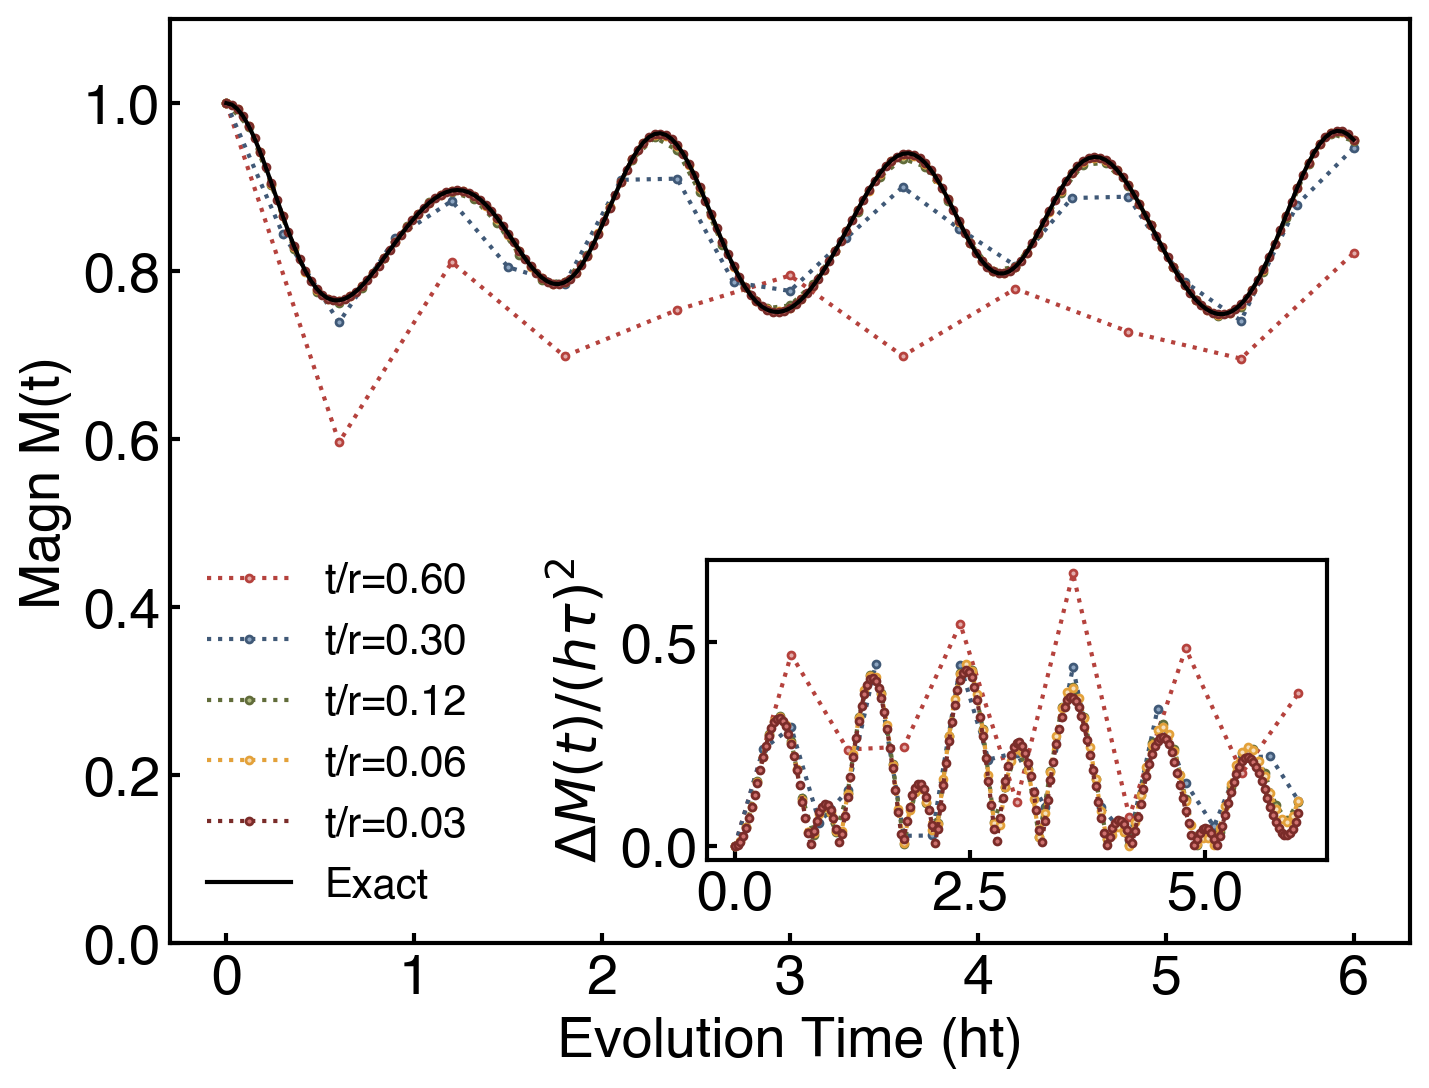

In [2]:
n, T = 6, 6
r_list = [10, 20, 50, 100, 200]

# J, h, g = 0.2, 1.0, 0.0
J, h, g = -1.0, -1.0, -1.0
tfI = TF_Ising_1d(n, J, h, g, pbc=True)
H_list = [h.to_matrix(True) for h in tfI.ham_parity]
# H_list = [h.to_matrix(True) for h in tfI.ham_xyz]
init_state = Statevector.from_label('0'*n)
magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1.) for i in range(0, n)], num_qubits=n).to_matrix()/(n)

# fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
inset_ax = inset_axes(ax1, width="50%", height=1.5, loc="lower right", borderpad=2)
for r in r_list:
    obpf = ObPF(H_list, magn_op, init_state, T, r)
    t_list = np.linspace(0, T, r+1)
    # print('t_list: ', t_list)
    # plot_evo(ax, t_list, obpf.data['magn']['exact'], '-')
    plot_evo(ax1, t_list, obpf.data['magn']['trott'], '.:', label=f't/r={T/r:.2f}')
    # plot_evo(ax2, t_list, ob_trott_err(obpf.data['magn'], abs=True), '.:', label=f't/r={T/r:.2f}')
    plot_evo(inset_ax, t_list, ob_trott_err(obpf.data['magn'])/(h*T/r)**2, '.:', label=f't/r={T/r:.2f}')

t_list = np.linspace(0, T, 200+1)
exact_magn = [init_state.data.conj().T @ expm(1j * t * sum(H_list).toarray()) @ magn_op @ expm(-1j * t * sum(H_list).toarray()) @ init_state.data for t in t_list]

plot_evo(ax1, t_list, exact_magn, 'k-', label=f'Exact')
ax1.set_ylabel('Magn M(t)')
ax1.set_ylim(0, 1.1)

ax1.set_xlabel('Evolution Time (ht)')
inset_ax.set_ylabel(r'$\Delta M(t)/(h\tau)^2$')
ax1.legend()
# ax2.legend()
# fig.savefig(f'../figs/recover_ob_localization_n={n}_T={T}.pdf', dpi=300, bbox_inches='tight')

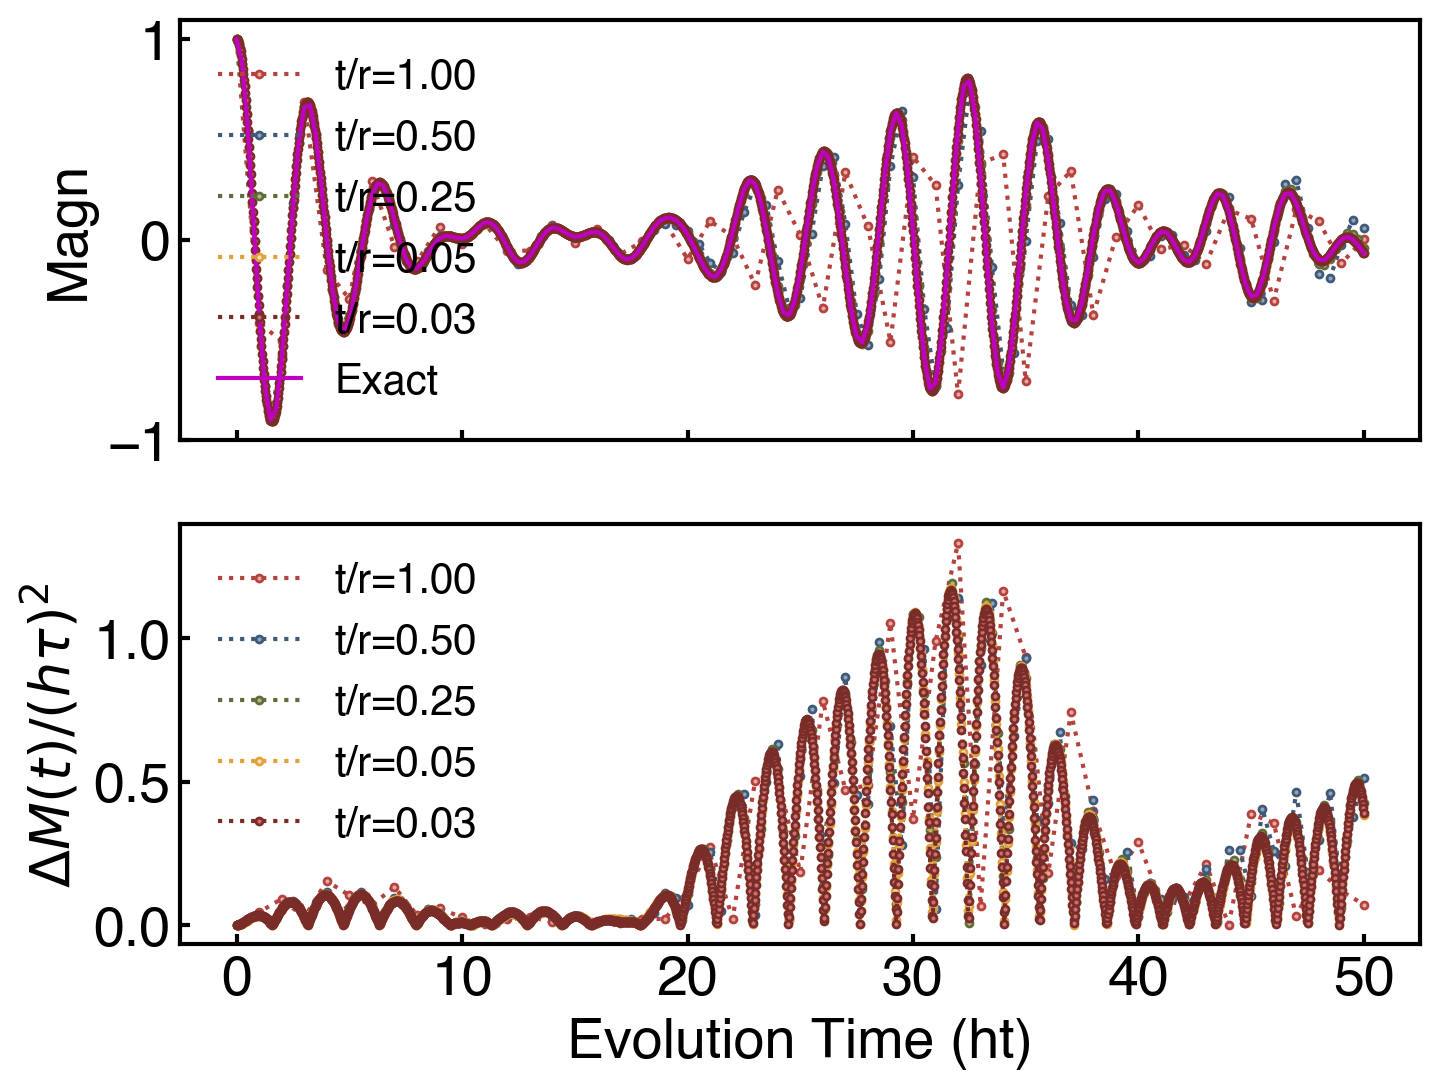

In [3]:
n, T = 6, 50
r_list = [50, 100, 200, 1000, 2000]

J, h, g = 0.2, 1.0, 0.0
# J, h, g = -1.0, -1.0, -1.0
tfI = TF_Ising_1d(n, J, h, g, pbc=True)
# H_list = [h.to_matrix(True) for h in tfI.ham_parity]
H_list = [h.to_matrix(True) for h in tfI.ham_xyz]
init_state = Statevector.from_label('0'*n)
magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1.) for i in range(0, n)], num_qubits=n).to_matrix()/n

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for r in r_list:
    obpf = ObPF(H_list, magn_op, init_state, T, r)
    t_list = np.linspace(0, T, r+1)
    # print('t_list: ', t_list)
    # plot_evo(ax, t_list, obpf.data['magn']['exact'], '-')
    plot_evo(ax1, t_list, obpf.data['magn']['trott'], '.:', label=f't/r={T/r:.2f}')
    # plot_evo(ax2, t_list, ob_trott_err(obpf.data['magn'], abs=True), '.:', label=f't/r={T/r:.2f}')
    plot_evo(ax2, t_list, ob_trott_err(obpf.data['magn'])/(h*T/r)**2, '.:', label=f't/r={T/r:.2f}')

t_list = np.linspace(0, T, 200+1)
exact_magn = [init_state.data.conj().T @ expm(1j * t * sum(H_list).toarray()) @ magn_op @ expm(-1j * t * sum(H_list).toarray()) @ init_state.data for t in t_list]

plot_evo(ax1, t_list, exact_magn, 'm-', label=f'Exact')
ax1.set_ylabel('Magn')

ax2.set_xlabel('Evolution Time (ht)')
ax2.set_ylabel(r'$\Delta M(t)/(h\tau)^2$')
ax1.legend()
ax2.legend()
# fig.savefig(f'../figs/ob_localization_n={n}_T={T}.pdf', dpi=300, bbox_inches='tight')